In [2]:
import os
import pdf2image
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
from openai import AzureOpenAI


archive_path = "DemoArkiv"
archive_path = os.path.abspath(os.getcwd()) + '/' + archive_path

with open("GPT.key", "r") as f:
    api_key = f.read()
with open("GPT.endpoint", "r") as f:
    azure_endpoint = f.read()
with open("GPT.deploymentName", "r") as f:
    azure_deployment = f.read()

client = AzureOpenAI(
    api_key=api_key,
    api_version="2024-02-01",
    azure_endpoint=azure_endpoint,
    azure_deployment=azure_deployment
) 

In [3]:
class DocNode:
    def __init__(self, id) -> None:
        self.next_node = None
        self.chunks = {}
        self.chunk_list = []
        self.summary = ""
        self.id = id

# Create linked list of nodes containing doc id in chronlogical order
files = [f for f in os.listdir(archive_path)]
files.sort()
root = None
head = None
while len(files) > 0:
    file = files.pop(0)
    print(file[37:-4])
    node = DocNode(int(file[37:-4]))# Doc ID is locataed from 37th first to the 5th last character of file name
    if root == None:
        root = node
        head = node
        print(head.id)
        continue
    head.next_node = node
    head = node
    print(head.id)

20045214
20045214
20048434
20048434
20055571
20055571
20070586
20070586
20077880
20077880
20080517
20080517
20082760
20082760
20087062
20087062
20093389
20093389
20094749
20094749
20111554
20111554
20114107
20114107
20114197
20114197
20114598
20114598
20131411
20131411
20132483
20132483
20133393
20133393
20145127
20145127
20151089
20151089
20273009
20273009
20428060
20428060
20428064
20428064
20436522
20436522
20436525
20436525
20436533
20436533


In [4]:
def get_text(id): # should look into foundation model ocr for time efficiency + accuracy
    template = os.listdir(archive_path)[0][:37]
    file = template + str(id) + '.pdf'
    imgs = pdf2image.convert_from_path(archive_path + '/' + file)
    text = ""
    for pg_nr, img in enumerate(imgs):
        pg_content = pytesseract.image_to_string(img, lang="nor")
        text = text + " " + pg_content
    return text

def get_chunks_from_gippity(text):
    # Ask GPT nicely for chunks :)
    sys_msg = '''
    Split the text into sections with atomic semantic meanings, meaning each section should have 1 connotation. Respond by listing the sections.
    Example:
    Q. Det var en gang i Krarup Kro en pike, som het Karen. Hun var alene om oppvartningen; for Kromannens kone gikk nesten alltid omkring og lette efter sine nøkler... Men når gamle folk ville gi ungdommen en riktig alvorlig advarsel pleide de gjerne å begynne således: ”Det var en gang i Krarup Kro en pike som het Karen”
    A. Det var en gang i Karup Kro en pike, som het Karen.
    Karen. Hun var alene om oppvartningen;
    for Kromannens kone gikk nesten alltid omkring og lette efter sine nøkler
    ...
    Men når gamle folk ville gi ungdommen en riktig alvorlig advarsel pleide de gjerne å begynne således:
    advarsel ”Det var en gang i Krarup Kro en pike som het Karen”
    Do not use indexing numbers.
    '''

    response = client.chat.completions.create(
    model=azure_deployment,
    messages=[
        {"role": "system", "content": sys_msg},
        {"role": "user", "content": text}
    ]
    )
    response_text = response.choices[0].message.content
    chunks = response_text.split("\n")

    return response_text, chunks

head = root
while head.next_node:
    if head.chunk_list != []:
        head = head.next_node
    text = get_text(head.id)
    string_chunks, chunk_list = get_chunks_from_gippity(text)
    head.chunk_list = chunk_list
    print(head.id)
    
    
    
    

20045214
20048434
20055571
20070586
20077880
20080517
20082760
20087062
20093389
20094749
20111554
20114107
20114197
20114598
20131411
20132483
20133393
20145127
20151089
20273009
20428060
20428064
20436522
20436525
20436533


In [5]:
print(head.chunk_list)

["SONGDALEN KOMMUNE '", 'TEKNISK ENHET å', '', 'Songdalen kommune v/Johnny Greibesland', '', 'Postboks 53', '4685 NODELAND', 'Vår ref. Deres ref. Dato:', '09/726-4/GBR-110//DBJ 05.06.2009', '', 'Delegert vedtak', '', 'SAKSGANG', "'Styre, utvalg, komité m.m. Møtedato f Saksnr. Saksbeh.", '| Delegert planutvalget 05.06.2009| 12309 | DBJ', '', 'Avgjort av: Arkiv: GBR-110/ Arkivsaknr:', 'Saksansv.: Diddi Bjoraa Objekt: 09/726 -3', '', 'Tillatelse til fradeling - Songdalsvegen 57 gnr. 110 parsell av bnr. 44 -', 'Songdalen kommune', '', 'Følgende dokumenter foreligger:', 'Nr T Dok.dato Avsender/Mottaker Tittel', '1 I 06.05.2009 PTL v/Gunnar Grana Delingssøknad Songdalsvegen 57 gnr.', '110 parsell av bnr. 44', '', 'Saksutredning:', '', 'Søknad:', 'Det søkes om fradeling av parsell på 3230 m² fra gnr. 110 bnr. 44, Songdalsvegen 57.', 'Parsellen skal benyttes til rådhus, offentlige kontorer og legesenter.', '', 'Gjeldende plangrunnlag:', 'Eiendommen omfattes av reguleingsplan for Fagermoen vedt

In [6]:
def order_chunks_with_gippity(chunk_text):
    # Ask GPT nicely to order chunks :)
    sys_msg = """
    Order the list of chunks from most to least important in regards to the result of the application(if the application was approved or not).
    Example:
    Q.
    Arne sender naboklage
    Kommunen sier det er ulovlig å bygge garasje
    Beate sin bil er blå.'
    Navn: Beate
    Beate får ikke lov til å bygge garasje
    A. 
    'Beate får ikke lov til å bygge garasje
    Kommunen sier det er ulovlig å bygge garasje
    Arne sender naboklage
    Beate sin bil er blå.'
    Navn: Beate

    Note that facts used in example are not necessarily indicative of real world importance or rules. Do not use indexing numbers. Do not change the content of the chunks. Do not combine or seperate chunks.
    """

    response = client.chat.completions.create(
    model=azure_deployment,
    messages=[
        {"role": "system", "content": sys_msg},
        {"role": "user", "content": chunk_text}
    ]
    )

    response_text = response.choices[0].message.content
    ordered_chunks = response_text.split("\n")

    return response_text, ordered_chunks

head = root
while head.next_node:
    chunk_string = "\n".join(head.chunk_list)
    #print("NEW CHUNK STRING: " + chunk_string)
    sorted_chunk_string, sorted_chunk_list = order_chunks_with_gippity(chunk_string)
    print(head.id)
    head = head.next_node
chunk_string = "\n".join(head.chunk_list)
sorted_string_chunks, sorted_chunk_list = order_chunks_with_gippity(chunk_string)    
print(head.id)

20045214
20048434
20055571
20070586
20077880
20080517
20082760
20087062
20093389
20094749
20111554
20114107
20114197
20114598
20131411
20132483
20133393
20145127
20151089
20273009
20428060
20428064
20436522
20436525
20436533


In [7]:
print(head.chunk_list)
print(sorted_chunk_list)

["SONGDALEN KOMMUNE '", 'TEKNISK ENHET å', '', 'Songdalen kommune v/Johnny Greibesland', '', 'Postboks 53', '4685 NODELAND', 'Vår ref. Deres ref. Dato:', '09/726-4/GBR-110//DBJ 05.06.2009', '', 'Delegert vedtak', '', 'SAKSGANG', "'Styre, utvalg, komité m.m. Møtedato f Saksnr. Saksbeh.", '| Delegert planutvalget 05.06.2009| 12309 | DBJ', '', 'Avgjort av: Arkiv: GBR-110/ Arkivsaknr:', 'Saksansv.: Diddi Bjoraa Objekt: 09/726 -3', '', 'Tillatelse til fradeling - Songdalsvegen 57 gnr. 110 parsell av bnr. 44 -', 'Songdalen kommune', '', 'Følgende dokumenter foreligger:', 'Nr T Dok.dato Avsender/Mottaker Tittel', '1 I 06.05.2009 PTL v/Gunnar Grana Delingssøknad Songdalsvegen 57 gnr.', '110 parsell av bnr. 44', '', 'Saksutredning:', '', 'Søknad:', 'Det søkes om fradeling av parsell på 3230 m² fra gnr. 110 bnr. 44, Songdalsvegen 57.', 'Parsellen skal benyttes til rådhus, offentlige kontorer og legesenter.', '', 'Gjeldende plangrunnlag:', 'Eiendommen omfattes av reguleingsplan for Fagermoen vedt

In [16]:
NUMBER_OF_CHUNKS_TO_CONSIDER = 10 # import numpy as np - use np.inf to include all chunks

def find_related_chunks_with_gippity(current_head, earlier_head):
    sys_msg = """
    Do any of the chunks from document1 affect any of the chunks from document2? If so which ones?
    A chunk is affected if that chunk's effect on a verdict of accepted/not accepted on a building matter application is altered.
    Assume that document1 is newer than document2.
    Reply 0-0 if no chunk affects any other chunk.
    Else: list the chunk relations (there can be one to many relations)
    The format is: 
    chunk_id_in_document_1-chunk_id_in_document_2

    Do not use indexing numbers.

    Example 1:
    Document1:
    1. Garasjen skal bygges på tomte grensen
    2. Nabo har signert at de vil ha garasje
    3. Garasjen skal være fin
    4. Garasjen skal være lav
    Document2:
    1. Garasjen skal bygges på tomte grensen
    2. Naboklage
    3. Garasjen skal være høy

    Answer:
    2-1
    4-3

    Example 2:
    Document1:
    1. Terassen skal være fin
    2. Terassen er plassert midt på tomten
    3. Fylkesmann har godkjent terasse
    Document2:
    1. Garasjen skal bygges på tomte grensen
    2. Naboklage
    3. Garasjen skal være høy

    Answer: 
    0-0
    """

    document1 = ""
    for i in range(min(NUMBER_OF_CHUNKS_TO_CONSIDER, len(current_head.chunk_list))):
        document1 = document1 + f"{i+1}. {current_head.chunk_list[i]}\n"
    document2 = ""
    for i in range(min(NUMBER_OF_CHUNKS_TO_CONSIDER, len(earlier_head.chunk_list))):
        document2 = document2 + f"{i+1}. {earlier_head.chunk_list[i]}\n"
        
    response = client.chat.completions.create(
    model=azure_deployment,
    messages=[
        {"role": "system", "content": sys_msg},
        {"role": "system", "content": document1},
        {"role": "user", "content": document2}
    ]
    )
    response_text = response.choices[0].message.content
    relation_list = response_text.split("\n")
    relation_list = list(filter(None, relation_list))
    #print(relation_list)

    if '0-0' not in relation_list:
        for relation in relation_list:
            c1, c2 = relation.split('-')
            c1 = int(c1)
            c2 = int(c2)

            if current_head.chunk_list[c1-1] not in current_head.chunks.keys():
                current_head.chunks[head.chunk_list[c1-1]] = {
                    "importance": c1-1,
                    "relations": []
                }
            current_head.chunks[current_head.chunk_list[c1-1]]["relations"].append((earlier_head, c2-1))


import time
head = root
while head.next_node:
    start_time = time.time()
    head = head.next_node
    head2 = root
    while head2 != head:
        find_related_chunks_with_gippity(head, head2)
        head2 = head2.next_node
    end_time = time.time()
    print(end_time-start_time)


0.37003254890441895
0.532548189163208
0.8190534114837646
0.987525463104248
1.579993486404419
36.612483739852905
4.5483996868133545
18.63608741760254
4.954025983810425
38.770392417907715
16.893181800842285
37.663679361343384
9-9
22.35318899154663
6.853461980819702
53.880913496017456
38.59703040122986
23.75349712371826
42.705899715423584
23.898255586624146
55.87507963180542
58.556782484054565
41.8388774394989
31.06117868423462
66.35538125038147


In [17]:
head = root
while head.next_node:
    for i, chunk in enumerate(head.chunk_list):
        if chunk not in head.chunks:
            head.chunks[head.chunk_list[i]] = {
                    "importance": i,
                    "relations": []
                }
    head=head.next_node
for i, chunk in enumerate(head.chunk_list):
        if chunk not in head.chunks:
            head.chunks[head.chunk_list[i]] = {
                    "importance": i,
                    "relations": []
            }

print(head.chunks)

{"SONGDALEN KOMMUNE '": {'importance': 0, 'relations': []}, 'TEKNISK ENHET å': {'importance': 1, 'relations': []}, '': {'importance': 2, 'relations': []}, 'Songdalen kommune v/Johnny Greibesland': {'importance': 3, 'relations': []}, 'Postboks 53': {'importance': 5, 'relations': []}, '4685 NODELAND': {'importance': 6, 'relations': []}, 'Vår ref. Deres ref. Dato:': {'importance': 7, 'relations': []}, '09/726-4/GBR-110//DBJ 05.06.2009': {'importance': 8, 'relations': []}, 'Delegert vedtak': {'importance': 10, 'relations': []}, 'SAKSGANG': {'importance': 12, 'relations': []}, "'Styre, utvalg, komité m.m. Møtedato f Saksnr. Saksbeh.": {'importance': 13, 'relations': []}, '| Delegert planutvalget 05.06.2009| 12309 | DBJ': {'importance': 14, 'relations': []}, 'Avgjort av: Arkiv: GBR-110/ Arkivsaknr:': {'importance': 16, 'relations': []}, 'Saksansv.: Diddi Bjoraa Objekt: 09/726 -3': {'importance': 17, 'relations': []}, 'Tillatelse til fradeling - Songdalsvegen 57 gnr. 110 parsell av bnr. 44 -'

In [24]:
def get_summary_from_gippity(doc):
    sys_msg = """Du er en KI assistent som oppsummerer PDFer. Oppsummer PDFen i henhold til tittel og den viktigste informasjonen i PDFen,
                den aller viktigste informasjonen er om søknaden er godkjent. Du skal oppsummere PDFen på under 30 ord. Ikke bruk addresse,
                navn, eller GNR/BNR (gårdsnummer/bruksnummer) i oppsummeringen. Om referanse til personer eller eiendom er viktig for oppsummering
                erstatt navn med funksjonsnavn som 'søker' eller 'søkers nabo' og adresse med eksempler som 'søkers eiendom' eller 'klagers eiendom'.
                Begynn alltid med år; ÅÅÅÅ: Dispensasjon godkjent/avslått, <pdf info>
                Du får i tillegg oppgitt de viktigste delene av teksten.
                Du får også oppgitt informasjon dette dokumentet endrer som var korrekt inntil dette dokumentet var vedtatt. Dette er ofte relevant for oppsummeringen.
                De relaterte delene er oppgitt i form av: "ny informasjon---gammel informasjon" eller 0---0 om det er ingen relaterte dokumenter.
                """


    important_chunks = ""

    for i, chunk in enumerate(doc.chunks.keys()):
        important_chunks = important_chunks + f"VIKTIG DEL {i+1}: {chunk}\n"

    related_chunks = ""

    for chunk in doc.chunks:
        if doc.chunks[chunk]["relations"] == []:
            continue
        related_chunks = related_chunks + f"{chunk}---{doc.chunks[chunk]['relations'][0][0].chunk_list[doc.chunks[chunk]['relations'][1]]}\n"
    
    if related_chunks == "":
        related_chunks = "0---0"

    response = client.chat.completions.create(
    model=azure_deployment,
    messages=[
        {"role": "system", "content": sys_msg},
        {"role": "system", "content": important_chunks},
        {"role": "system", "content": related_chunks}
    ]
    )
    summary = response.choices[0].message.content    

    head.summary = summary

head = root
while head.next_node:
    get_summary_from_gippity(head)
    head = head.next_node
get_summary_from_gippity(head)

In [ ]:
head = root
while head.next_node:
    print(head.summary)
    head = head.next_node
print(head.summary)

2004: Dispensasjon godkjent, delvis igangsettingstillatelse for Frobusdalen 3A, inkludert utstikking, rørleggerarbeid, grunn og betongarbeider, på eget ansvar.
2004: Dispensasjon godkjent, klage fra naboer på vedtak om nytt boligbygg i Frobusdalen 3A tas ikke til følge.
2004: Dispensasjon godkjent, søknad om igangsettingstillatelse for boligblokk i Frobusdalen 3 er godkjent.
2004: Dispensasjon godkjent, Fylkesmannen opprettholder vedtaket om rammetillatelse for nybygg med 10 boenheter på søkers eiendom tross klager om saksbehandlingsfeil og ulemper for naboer.


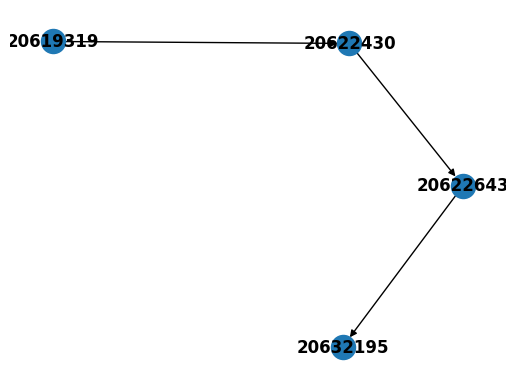

In [ ]:
import networkx as nx

G = nx.DiGraph()

head = root
while head.next_node:
    if G.number_of_nodes() == 0:
        G.add_node(head.id)
        last_node = head.id
    head=head.next_node
    G.add_node(head.id)
    G.add_edge(last_node, head.id)
    last_node = head.id

head = root
while head.next_node:
    head=head.next_node
    has_relation = False
    for chunk in head.chunks:
        if head.chunks[chunk]["relations"] != []:
            has_relation = True
            relation_to = head.chunks[chunk]["relations"][0]
            break
    if has_relation:
        G.add_edge(head.id, relation_to.id)
    
import matplotlib.pyplot as plt
subax1 = plt.subplot(111)
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()
